## Impluse MACD 期貨交易策略
### 前言
LazyBear 是在國際知名交易平台 TradingView上極具影響力的指標開發者。他創作了大量廣受歡迎的客製化技術指標，其開源的程式碼啟發了全球無數量化交易員與技術分析愛好者。LazyBear 的指標通常專注於改善傳統指標的延遲性，並結合獨特的市場觀察來捕捉趨勢與動能。本次採用的「Impulse MACD」即為他的代表作之一。此指標並非傳統的指數平滑異同移動平均線（MACD），而是進行了顯著的改良：它使用零延遲的雙指數移動平均線（DEMA）來更快速地響應價格變化，並結合平滑化（SMMA）的高低價通道來判斷市場的「衝量」（Impulse）。其核心思想是，只有當價格動能與趨勢方向一致時，產生的交易信號才更具價值，藉此過濾掉部分盤整行情中的雜訊。
### 投資標的與回測期間
本研究以台灣指數期貨（台指期, TX）作為唯一的交易標的，並使用每日的最高價、最低價與收盤價資料進行指標計算與回測。由於策略中的指標（如DEMA、SMMA）需要一段時間的歷史數據進行預熱（warm-up），最長的計算週期為 30 天，且為了確保回測開始時有足夠穩定的歷史數據，實際回測期間訂為2019年1月1日至2025年9月12日，以確保所有交易信號的嚴謹性與有效性

### 核心邏輯
1. **指標系統 (Indicator System):**
    - 計算 HLC/3 (高、低、收盤價的平均)。
    - 使用零延遲雙指數移動平均 (DEMA) 來快速反應價格變化。
    - 透過價格與高/低價平滑移動平均通道（SMMA）的關係，計算出主要的動盪指標 `md` (快線)。
    - 對 `md` 進行簡單移動平均，得到信號線 `sb` (慢線)。
2. **進場信號 (Entry Siganl):**
    - 當快線 `md` 由下往上穿越慢線 `sb` 時，產生買進信號。
    - 當快線 `md` 由上往下穿越慢線 `sb` 時，產生賣出信號。
3. **出場與風險管理 (Exit & Risk Management):**
    - 採用基於 ATR (平均真實波幅) 的移動停損 (Trailing Stop-Loss) 機制。
    - 停損點會隨著價格朝著對倉位有利的方向動態調整，藉此鎖定利潤並嚴格控制下檔風險。
4. **合約轉倉 (Contract Rolling):**
    -在期貨合約到期前，策略會自動將即將到期的合約平倉，並在新的近月合約上建立相同的部位，以確保回測的連續性。
    




### 一、 環境設定與導入所需套件
#### 1.1 導入資料
首先，我們需要設定 TEJ API 的金鑰以存取資料庫。接著，透過環境變數指定回測所需的標的 (台指期貨 `TX` 與大盤 `IR0001`) 及資料期間。最後，使用 `zipline ingest` 指令將這些資料匯入 Zipline 的本地資料庫中，以提供回測使用。




In [7]:
import os
import yaml

notebook_dir = os.path.dirname(os.path.abspath(__file__)) if '__file__' in globals() else os.getcwd()
yaml_path = os.path.join(notebook_dir, '..', 'config.yaml')
yaml_path = os.path.abspath(os.path.join(notebook_dir, '..', 'config.yaml'))
print(f"Loading configuration from: {yaml_path}")

with open(yaml_path, 'r') as tejapi_settings:
    config = yaml.safe_load(tejapi_settings)

os.environ['TEJAPI_BASE']   = config['TEJAPI_BASE']
os.environ['TEJAPI_KEY']    = config['TEJAPI_KEY']
os.environ['future'] = 'TX'
os.environ['ticker'] = 'IR0001'
os.environ['mdate'] = '20100101 20250925'
!zipline ingest -b tquant_future

Loading configuration from: c:\Users\Gary\OneDrive\文件\240_TEJ_Summary\5_Future\config.yaml
Merging daily equity files:


[2025-10-01 06:29:18.366166] INFO: zipline.data.bundles.core: Ingesting tquant_future.
[2025-10-01 06:29:25.133582] INFO: zipline.data.bundles.core: Ingest tquant_future successfully.


#### 1.2 導入套件
導入本次策略時作所需的 Python 套件，包含 `pandas`、 `numpy` 、 `talib` 以及 Zipline 框架中的各項核心功能。

In [8]:
import numpy as np
import pandas as pd
import talib
import pyfolio as pf   # 使用 pyfolio 進行回測
from zipline.api import (
    order_target,      # 持倉的目標口數
    order,             # 下單加減多少口數 
    cancel_order,      # 取消訂單
    get_open_orders,   # 拿到所有掛單
    get_order,         # 用訂單ID查詢訂單狀態
    record,            # 把指標或任何想記錄的數值記錄到回測結果
    continuous_future, # zipline 自動換月
    schedule_function, # 安排排程，在指定日期 / 時間呼叫 func
    date_rules,        # 搭配 schedule_function 的日期 / 時間規則
    time_rules,        
    set_commission,    # 設定手續費模型
    set_slippage,      # 設定滑價模型
    set_benchmark,     # 設定績效比較基準
    symbol             # 取得一個可交易 / 引用的資產物件
)
from zipline.finance.execution import StopOrder           # 停損市價單
from zipline.finance import commission, slippage          # 費用模型 / 滑價模型命名空間
from zipline import run_algorithm                         # 回測主入口
from zipline.utils.run_algo import get_transaction_detail # 把 results 拆成positions / transaction / orders三張表
from zipline.utils.calendar_utils import get_calendar     # 取得交易所行事曆
import matplotlib.pyplot as plt

## 二、 指標計算函數
為了實現 Impluse MACD 策略，我們需要定義兩個關鍵的輔助函數:
- `_smma` : 計算平滑移動平均線 (Smoothed Moving Average)，這是後續指標的基礎。
- `calculate_indicators` : 此函數整合了所有指標的計算邏輯，包含 HLC/3、ATR、高低價通道的 SMMA，以及最終的快線 `md` 與慢線 `sb`。這是策略信號的核心。 

In [9]:
import talib
import pandas as pd
def _smma(series, period):
    """計算平滑移動平均線(smoothing moving average)"""
    smma_output = pd.Series(np.nan, index=series.index)
    sma_val = talib.SMA(series, timeperiod=period)
    first_valid_index = sma_val.first_valid_index()
    if first_valid_index is None:
        return smma_output
    try:
        start_loc = series.index.get_loc(first_valid_index)
    except KeyError:
        return smma_output
    smma_output.loc[first_valid_index] = sma_val.loc[first_valid_index]
    for i in range(start_loc + 1, len(series)):
        prev_smma = smma_output.iloc[i - 1]
        current_val = series.iloc[i]
        if pd.notna(prev_smma) and pd.notna(current_val):
            smma_output.iloc[i] = (prev_smma * (period - 1) + current_val) / period
        else:
            smma_output.iloc[i] = np.nan
    return smma_output

def calculate_indicators(data, ma_len, sig_len, atr_len):
    """計算完整的 Impluse macd 指標和 ATR"""
    data['hlc3'] = (data['high'] + data['low'] + data['close']) / 3
    data['atr'] = talib.ATR(data['high'], data['low'], data['close'], timeperiod=atr_len)
    data['High_smma'] = _smma(data['high'], period=ma_len)
    data['Low_smma'] = _smma(data['low'], period=ma_len)
    data['hlc3_zlema'] = talib.DEMA(data['hlc3'], timeperiod=ma_len)
    data['md'] = np.where(data['hlc3_zlema'] > data['High_smma'], 
                          data['hlc3_zlema'] - data['High_smma'],
                          np.where(data['hlc3_zlema'] < data['Low_smma'], data['hlc3_zlema'] - data['Low_smma'], 0))
    data['sb'] = talib.SMA(data['md'], timeperiod=sig_len)
    return data

### 三、建構 Zipline 交易策略
#### 3.1 `initialize` 函數：策略初始化
在 `initialized` 函數中，我們進行回測開始前的一次性設定。這包括：
- **策略參數:** 設定指標計算所需的時間週期 (`ma_len`, `sig_len`) 以及 ATR 停損的乘數 (`atr_multiplier`)。
- **資產設定:** 定義要交易的 `continous_future` 連續合約物件。
- **交易成本:** 設定手續費 (`commisson`) 與滑價 (`slippage`) 模型，讓回測結果更貼近真實。
- **績效基準:** 設定加權股價報酬指數 (`IR001`) 作為策略績效的比較基準。
- **排程設定:** 使用`schedule_function` 安排每日要執行的交易邏輯 (`daily_tarde`) 與收盤後執行的轉倉檢查 (`roll_futures`)


In [10]:
def initialize(context):
    '''
    策略初始化函數, 用來設定全域參數、資產、手續費/滑價、與排程
    context是一個物件, 像一個可寫入的「工具箱、命名空間」
    '''
    context.ma_len = 30
    context.sig_len = 8
    context.atr_len = 20
    context.atr_multiplier = 3.25    
    context.future = continuous_future('TX', offset = 0, roll = 'calendar', adjustment = 'add') # 建立台指期連續合約資產，之後用他下單與取價
    set_commission(futures = commission.PerContract(cost = 200, exchange_fee = 0))
    set_slippage(futures = slippage.FixedSlippage(spread = 10.0))
    set_benchmark(symbol('IR0001')) # 設定大盤為比較基準
    context.stop_loss_price = None  # 目前生效的止損價格
    context.stop_order_id = None    # 已送出的stop單，方便之後修改、取消
    # 每天執行交易策略
    schedule_function(func = daily_trade, date_rule = date_rules.every_day(), time_rule = time_rules.market_open(minutes = 30))
    # 每天檢查是否要轉倉
    schedule_function(func = roll_futures, date_rule = date_rules.every_day(), time_rule = time_rules.market_close())

#### 3.2 `daily_trade` 函數: 每日交易與風險控制
此函數會在每個交易日被調用，是策略的核心。主要步驟如下：
1. **數據獲取與指標計算:** 獲取最新的歷史價格數據，並呼叫 `calculate_indicators` 計算出 `md`、`sb`、`atr`。
2. **信號產生:** 根據 `md`、`sb` 的黃金交叉或死亡交叉來產生 `buy_siganl` 或 `sell_signal`。
3. **倉位管理與 `_get_tx_chain_state` 的作用:**
    - 在處理期貨時，我們不能只檢查 `context.portfolio.positions` 中是否有當前的連續合約(`context.future`)。因為在轉倉期間，我們的實際部位可能還留在即將到期的舊合約上，而 `context.future` 已經指向了新合約。
    - 如果只做簡單的檢查，會誤以為沒有倉位而下單，導致在不同月份的合約上持有多個部位 (意外加倉)。
    - 因此， `_get_tx_chain_state` 這個輔助函數會遍歷所有持倉，檢查資產的 `root_symbol` 是否為 'TX'，從而準確地判斷我們在整個台指期或產品鏈上總共持有的口數 (`root_aty`)，避免了轉倉重複下單問題。
4. **移動停損邏輯:**
    - 無倉位時: 如果當前沒有倉位，則根據買賣信號建立新的多頭或空頭倉位。
    - 持倉時: 如果當前持有倉位，則啟動 ATR 移動停損機制。停損點只會朝著對倉位有利的方向移動 (保護利潤)，並透過 zipline 的 `StopOrder` 實現。如果停損點需要更新，會先取消就訂單再掛上新訂單。 

In [11]:
def _get_tx_chain_state(context, root = 'tx'):
    '''掃描所有部位，找出台指期的口數'''
    active_asset = None
    root_qty = 0
    for a, p in context.portfolio.positions.items():
        if getattr(a, 'root_symbol', None) == root and p and p.amount != 0:
            root_qty += p.amount
            if active_asset is None:
                active_asset = a
    return active_asset, root_qty


def daily_trade(context, data):
    '''每日執行的交易邏輯'''
    try:
        # 跟zipline要250根日線的歷史資料
        hist = data.history(context.future, ['high', 'low', 'close'], bar_count = 250, frequency = '1d')
        indicators = calculate_indicators(data = hist, ma_len = context.ma_len, sig_len = context.sig_len, atr_len = context.atr_len)
        md = indicators['md']
        sb = indicators['sb']
        atr = indicators['atr'].iloc[-1]
        current_price = data.current(context.future, 'price') # 取當前價格
    except Exception as e:
        print(f'指標計算錯誤: {e}')
        return
    # 產生買賣訊號
    buy_signal = (md.iloc[-2] < sb.iloc[-2]) and (md.iloc[-1] > sb.iloc[-1])
    sell_signal = (md.iloc[-2] > sb.iloc[-2]) and (md.iloc[-1] < sb.iloc[-1])
    # 取當月合約與目前持倉, 連續合約會在某一天切換到新月但持倉可能還在舊月
    current_contract = data.current(context.future, 'contract')
    held_asset, root_qty = _get_tx_chain_state(context, 'TX')
    
    if root_qty != 0:
        pos_asset = held_asset
        pos = context.portfolio.positions[pos_asset]
        px = data.current(context.future, 'price')
        if context.stop_loss_price is None:
            # 初始建立止損單
            if pos.amount > 0:
                context.stop_loss_price = current_price - context.atr_multiplier * atr
            elif pos.amount < 0:
                context.stop_loss_price = current_price + context.atr_multiplier * atr
            amount = -pos.amount
            # 送出一張市價止損單
            context.stop_order_id = order(pos_asset, amount, style = StopOrder(context.stop_loss_price))
        else:
            # 已有止損, 止損價只往有利方向前進
            if pos.amount > 0:
                new_stop_price = current_price - context.atr_multiplier * atr
                context.stop_loss_price = max(new_stop_price, context.stop_loss_price)
            elif pos.amount < 0:
                new_stop_price = current_price + context.atr_multiplier * atr
                context.stop_loss_price = min(new_stop_price, context.stop_loss_price)
            # 原本有掛止損單
            if context.stop_order_id:
                stop_order_object = get_order(context.stop_order_id)
                if stop_order_object and stop_order_object.status == 0: # status == 0, 訂單處於open狀態
                    if stop_order_object.stop != context.stop_loss_price:
                        cancel_order(context.stop_order_id)
                        amount = -pos.amount
                        context.stop_order_id = order(pos_asset, amount, style = StopOrder(context.stop_loss_price))
                else:
                    context.stop_order_id = None
    else:
        # 無倉位卻有殘留停損單, 取消並清空紀錄
        if context.stop_order_id:
            stop_order_object = get_order(context.stop_order_id)
            if stop_order_object and stop_order_object.status == 0:
                cancel_order(context.stop_order_id)
            context.stop_order_id = None
        context.stop_loss_price = None
        if buy_signal:
            order_target(current_contract, 1)
        elif sell_signal:
            order_target(current_contract, -1)
    record(
        price = current_price,
        md = md.iloc[-1],
        sb = sb.iloc[-1],
        stop_loss = context.stop_loss_price
    )

### 3.3 `roll_futures`函數: 期貨轉倉
此函數會在每日收盤後檢查持有的期貨合約是否即將到期（5天內）。如過是，則會自動將舊合約的倉位平倉，並在新月份的合約上建立相同數量的倉位，同時為新倉位掛上初始的移動止損單。

In [12]:
def roll_futures(context, data):
    '''處理期貨轉倉, initialize會在每日收盤前呼叫'''
    for asset, pos in context.portfolio.positions.items():
        if not pos or pos.amount == 0:
            continue
        acd = getattr(asset, 'auto_close_date', None) 
        if not acd:
            continue                # 只選期貨資產（有到期日的）
        days_to_auto_close = (acd.date() - data.current_session.date()).days
        if days_to_auto_close > 5:
            continue                # 到到期日還剩五天以上不轉倉
        new_contract = data.current(context.future, "contract")
        if new_contract == asset:
            continue                # 已經是當前月份不需轉倉
        for o in get_open_orders(asset):
            cancel_order(o.id)      # 取消所有掛單
        context.stop_loss_price = None
        context.stop_order_id = None
        # 重新讀一次口數
        qty = context.portfolio.positions[asset].amount
        if qty != 0:
            print(f"執行轉倉: 從 {asset.symbol} 到 {new_contract.symbol}, 口數 {qty}")
            order_target(asset, 0)          # 關掉舊倉
            order_target(new_contract, qty) # 開新合約倉
            try:
                hist = data.history(context.future, ['high', 'low', 'close'], bar_count = 250, frequency = '1d')
                atr = talib.ATR(hist['high'], hist['low'], hist['close'], timeperiod = context.atr_len).iloc[-1]
                px = data.current(context.future, 'price')
                # 掛新止損單
                if qty > 0:
                    new_stop = px - context.atr_multiplier * atr
                elif qty < 0:
                    new_stop = px + context.atr_multiplier * atr
                context.stop_loss_price = new_stop
                context.stop_order_id = order(new_contract, -qty, style = StopOrder(context.stop_loss_price))
            except Exception as e:
                print(f"[roll future] 新合約掛單失敗: {e}")
            break

### 四、執行回測
設定回測的起迄時間、初始資金等參數，並呼叫 `run_algorithm` 來啟動整個回測流程。回測結果會儲存在 `results` 物件中。

In [13]:
start_date = pd.Timestamp('2019-01-01', tz = 'utc')
end_date = pd.Timestamp('2025-09-19', tz = 'utc')

# 呼叫zipline主入口
results = run_algorithm(
    start = start_date,
    end = end_date,
    initialize = initialize,
    capital_base = 1000000,
    data_frequency = 'daily',
    bundle = 'tquant_future',
    trading_calendar = get_calendar('TEJ')
)
print("回測完成")

執行轉倉: 從 TX201901 到 TX201902, 口數 1
執行轉倉: 從 TX201902 到 TX201903, 口數 1
執行轉倉: 從 TX201903 到 TX201904, 口數 1
執行轉倉: 從 TX201904 到 TX201905, 口數 1
執行轉倉: 從 TX201906 到 TX201907, 口數 1
執行轉倉: 從 TX201907 到 TX201908, 口數 1
執行轉倉: 從 TX201909 到 TX201910, 口數 1
執行轉倉: 從 TX201910 到 TX201911, 口數 1
執行轉倉: 從 TX201911 到 TX201912, 口數 1
執行轉倉: 從 TX201912 到 TX202001, 口數 1
執行轉倉: 從 TX202004 到 TX202005, 口數 1
執行轉倉: 從 TX202005 到 TX202006, 口數 1
執行轉倉: 從 TX202006 到 TX202007, 口數 1
執行轉倉: 從 TX202007 到 TX202008, 口數 1
執行轉倉: 從 TX202008 到 TX202009, 口數 1
執行轉倉: 從 TX202009 到 TX202010, 口數 1
執行轉倉: 從 TX202010 到 TX202011, 口數 1
執行轉倉: 從 TX202011 到 TX202012, 口數 1
執行轉倉: 從 TX202012 到 TX202101, 口數 1
執行轉倉: 從 TX202101 到 TX202102, 口數 1
執行轉倉: 從 TX202103 到 TX202104, 口數 1
執行轉倉: 從 TX202104 到 TX202105, 口數 1
執行轉倉: 從 TX202106 到 TX202107, 口數 1
執行轉倉: 從 TX202107 到 TX202108, 口數 1
執行轉倉: 從 TX202110 到 TX202111, 口數 -1
執行轉倉: 從 TX202112 到 TX202201, 口數 -1
執行轉倉: 從 TX202206 到 TX202207, 口數 1
執行轉倉: 從 TX202207 到 TX202208, 口數 1
執行轉倉: 從 TX202208 到 TX202209, 口數 1
執行轉倉: 從 TX20

### 五、策略績效分析
#### 5.1 計算關鍵績效指標 (KPIs)
回測結束後，我們從 `results` 物件中提取數據，計算策略本身以及大盤的各項關鍵績效指標，例如累積報酬、年化報酬、夏普比率、最大回撤等，並將結果打印出來以便比較。

------ 大盤績效指標 ------


Start date,2019-01-02
End date,2025-09-19
Total months,77
,Backtest
Annual return,20.501%
Cumulative returns,234.83%
Annual volatility,18.713%
Sharpe ratio,1.09
Calmar ratio,0.72
Stability,0.89
Max drawdown,-28.553%


------ 策略績效指標 ------


Start date,2019-01-02
End date,2025-09-19
Total months,77
,Backtest
Annual return,28.735%
Cumulative returns,413.88%
Annual volatility,18.79%
Sharpe ratio,1.44
Calmar ratio,0.90
Stability,0.75
Max drawdown,-31.882%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,31.88,2021-07-15,2022-11-03,2024-03-06,642
1,18.40,2024-07-11,2024-11-29,2025-03-31,172
2,13.27,2024-04-09,2024-05-09,2024-06-19,50
3,10.98,2021-01-19,2021-03-08,2021-04-19,55
4,10.08,2020-09-17,2020-10-30,2020-11-17,41


findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial Unicode MS
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial Unicode MS
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial Unicode MS
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial Unicode MS
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial Unicode MS
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial Unicode MS
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial Unicode MS
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial Unicode MS
findfont: Generic family 'sans-serif' not found because none of the foll

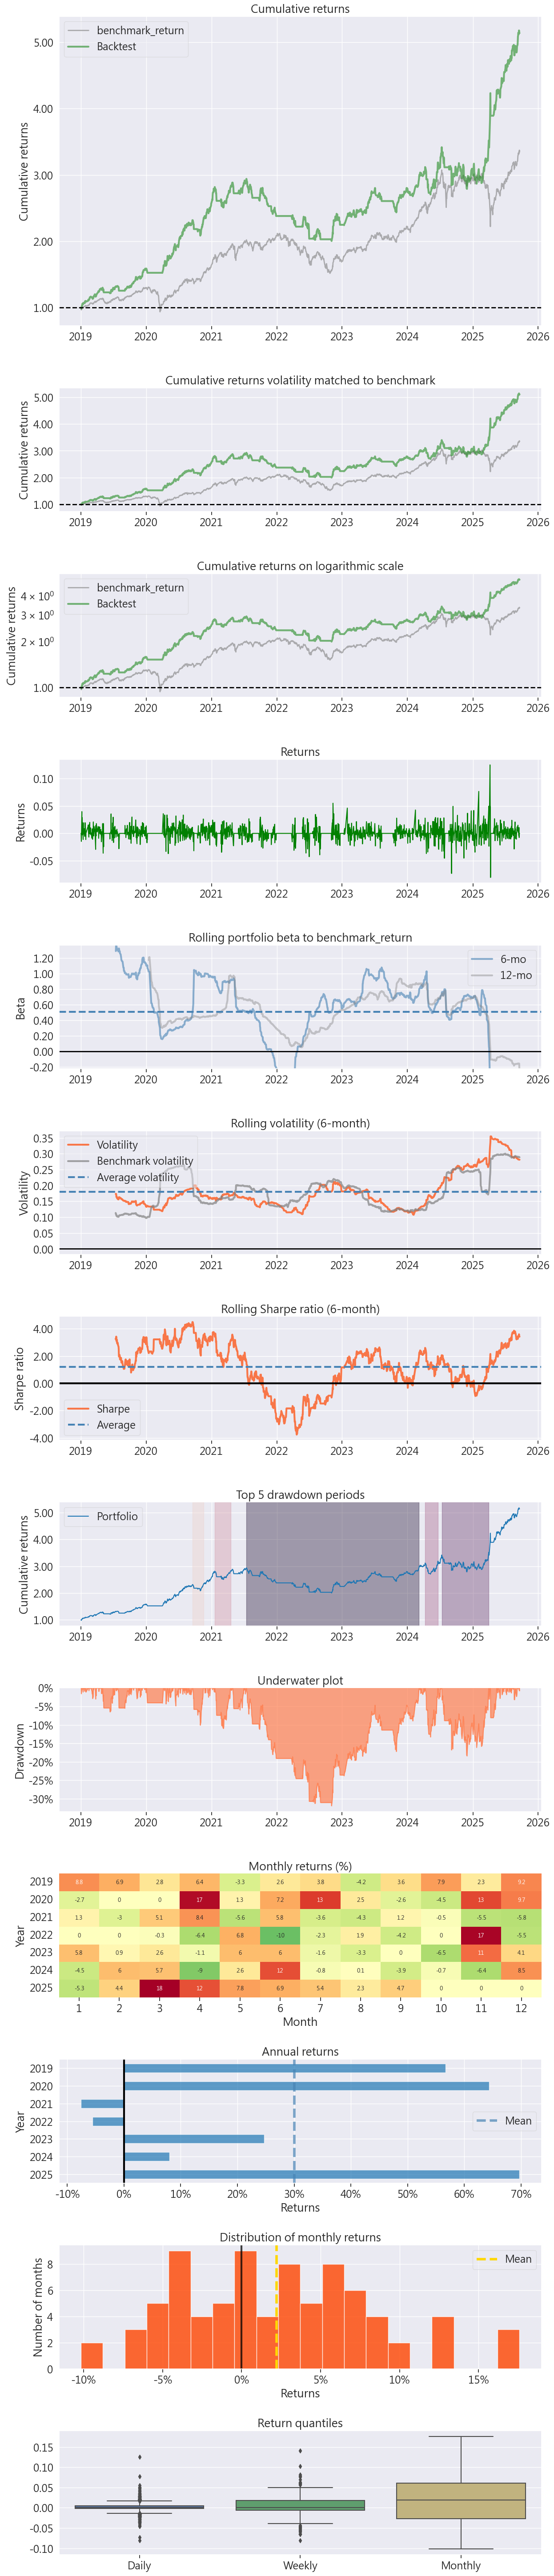

In [14]:
# 從 Zipline 的 results 物件中提取 Pyfolio 所需的數據格式
returns, positions, transactions = pf.utils.extract_rets_pos_txn_from_zipline(results)

# 提取基準報酬（benchmark returns）
benchmark_rets = results.benchmark_return

# 基準報酬指標
print("------ 大盤績效指標 ------")
pf.show_perf_stats(benchmark_rets)

# 產生完整的 Pyfolio 績效分析報告
print("------ 策略績效指標 ------")
pf.create_returns_tear_sheet(
    returns = returns,
    positions = positions,
    transactions = transactions,
    benchmark_rets = benchmark_rets,
)